# Fine-tuning the AlexNet model

## Introduction

As proposed in the book "Mastering Pytorch", we will fine-tune the AlexNet model for a specific dataset.
The idea is to make use of a pretrained model of the PyTorch repository and to adapt it to our dataset.

AlexNet is a successor of LeNet-5, which was one of the first convolutional neural networks. It was developed by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton. AlexNet was the first deep network trained on GPU, which was able to win the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2012. The network was trained on 1.2 million images from the ImageNet dataset with 1000 categories.
AlexNet is based on a similar architecture as LeNet-5, but it is much deeper and wider. It consists of eight layers, five convolutional layers, and three fully connected layers. It established the trend of uniform and modular structure by repeatdely stacking convolutional layers. The design increases the width of feature maps with the depth in the structure.The network architecture is shown in the following figures:

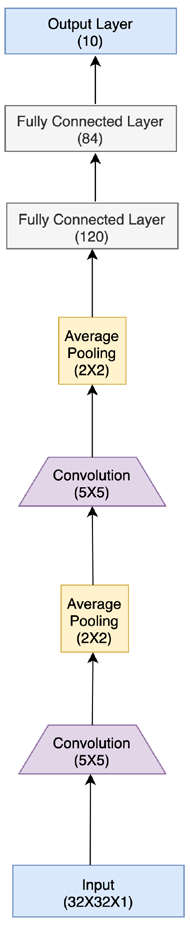

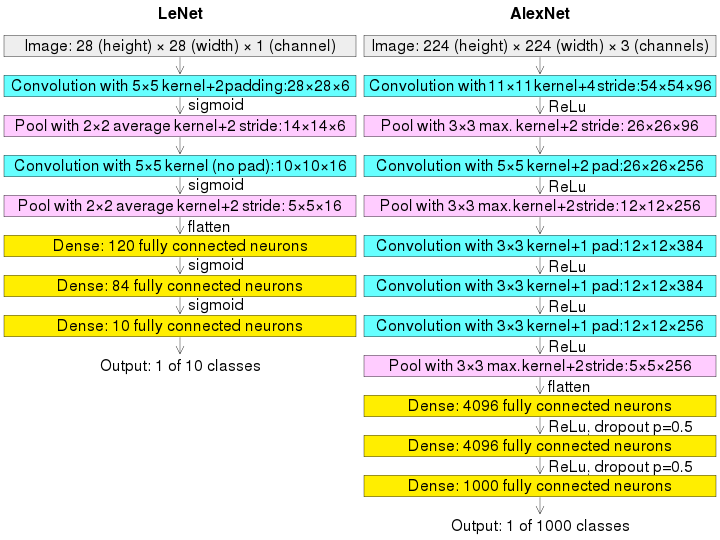

> If you intend to implement from scratch the architecture of AlexNet, please be aware that the **class definition given in the book (Mastering Pytorch, page 83) does not provide the right specification of Layers**. For example, it defines a feature map of 64 channels in the 1st convolutional layer, instead of 96, this does not even match half of the network specification if it intended to split the network on 2 GPUs.
>
> I advise to not implement and train the network from scratch as the number of parameters is huge and the training time is very long.

## Installation of technical requirements

On the contrary to what is done in the book, I chose to develop this model by using pytorch 2 (instead of v1.4).
This notebook is designed to be standalone, definining its own environment, to be executed with a GPU for example in Google Collab.

In [1]:
!pip install torch==2.0.1
!pip install torchvision==0.15.2
!pip install Pillow==10.0.1
!pip install pycocotools==2.0.7
!pip install matplotlib==3.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 78.6 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


### Importing the required packages

In [1]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

torch.manual_seed(0)

## Preparing the dataset

### Dataset information

- There are 240 training images and 150 validation images divided equally between the two classes (bees and ants).
- We download the dataset from this link - https://www.kaggle.com/ajayrana/hymenoptera-data and store it in the current working directory.
- In order to download the dataset you will need to login to kaggle. If you do not already have a kaggle account, you will need to register.
- More information about the dataset can be found here: https://hymenoptera.elsiklab.missouri.edu/


### Uploading the dataset from my Kaggle acount

Uploading the dataset from my Kaggle acount using the kaggle token stored in my Google Drive.

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
kaggle_token_path = "/content/drive/MyDrive/Kaggle/kaggle.json"
!ls {kaggle_token_path}

# Getting your kaggle token from your G-drive
!pip install kaggle
!mkdir -p ~/.kaggle
!cp {kaggle_token_path} ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

/content/drive/MyDrive/Kaggle/kaggle.json


In [10]:
# Downloading the dataset from the competition: MFT: the dataset does not respect kaggle requirements, so you will have to download it manually
# In my case, I saved it in my G-drive
# competition_name = "hymenoptera_data"
# !kaggle competitions download -c {competition_name}
# !mkdir kaggle_data
# !unzip {competition_name + ".zip"} -d kaggle_data
!unzip "/content/drive/MyDrive/Kaggle/archive.zip" -d kaggle_data
# MFT: The dataset directory "hymenoptera_data" contains a copy of itself that you can remove if you want, it is probably a mistake of the dataset author.

Archive:  /content/drive/MyDrive/Kaggle/archive.zip
  inflating: kaggle_data/hymenoptera_data/hymenoptera_data/train/ants/0013035.jpg  
  inflating: kaggle_data/hymenoptera_data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: kaggle_data/hymenoptera_data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: kaggle_data/hymenoptera_data/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: kaggle_data/hymenoptera_data/hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: kaggle_data/hymenoptera_data/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: kaggle_data/hymenoptera_data/hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: kaggle_data/hymenoptera_data/hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: kaggle_data/hymenoptera_data/hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: kaggle_data/hymenoptera_data/hymenoptera_data/train/ants/132478121_2

## Defining data loaders and transformers

In [12]:
ddir = "kaggle_data/"+"hymenoptera_data"

# Data normalization and augmentation transformations for train dataset
# Only normalization transformation for validation dataset
# The mean and std for normalization are calculated as the mean of all pixel values for all images in the training set per each image channel - R, G and B

data_transformers = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])]),
    'val': transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])])}

img_data = {k: datasets.ImageFolder(os.path.join(ddir, k), data_transformers[k]) for k in ['train', 'val']}
dloaders = {k: torch.utils.data.DataLoader(img_data[k], batch_size=8, shuffle=True, num_workers=2)
            for k in ['train', 'val']}
dset_sizes = {x: len(img_data[x]) for x in ['train', 'val']}
classes = img_data['train'].classes
dvc = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Checking some samples and that data loaders work

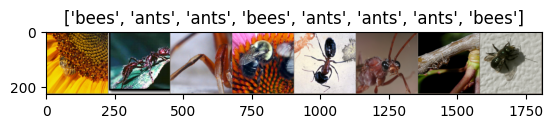

In [13]:
def imageshow(img, text=None):
    img = img.numpy().transpose((1, 2, 0))
    avg = np.array([0.490, 0.449, 0.411])
    stddev = np.array([0.231, 0.221, 0.230])
    img = stddev * img + avg
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if text is not None:
        plt.title(text)

# Generate one train dataset batch
imgs, cls = next(iter(dloaders['train']))

# Generate a grid from batch
grid = torchvision.utils.make_grid(imgs)

imageshow(grid, text=[classes[c] for c in cls])

## Fine-tuning the model

### Loading the pre-trained model from pytorch repository


In [20]:
# Listing all available pretrained models in torchvision
print("The pretrained models available for classification are:")
print(models.list_models(module=torchvision.models)) # seems to list only classification models
print("The pretrained models available for semantic segmentation are:")
print(models.list_models(module=torchvision.models.segmentation))
print("The pretrained models available for object detection are:")
print(models.list_models(module=torchvision.models.detection))

The pretrained models available for classification are:
['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'googlenet', 'inception_v3', 'maxvit_t', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext101_64x4d', 'resnext50_32x4d', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 's

In [14]:
model_pretrained = models.alexnet(pretrained=True)
# Display the feature embedding structure
print(model_pretrained.features)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 177MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [15]:
# Display the classifier structure
print(model_pretrained.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


### Defining the fine-tuning procedure




In [21]:
# MFT: added few args in the orginal code, to not make use of global variables because it was too uggly
def finetune_model(pretrained_model, loss_func, optim, data_loaders, device, epochs=10):
    start = time.time()

    model_weights = copy.deepcopy(pretrained_model.state_dict())
    accuracy = 0.0

    for e in range(epochs):
        print(f'Epoch number {e}/{epochs - 1}')
        print('=' * 20)

        # for each epoch we run through the training and validation set
        for dset in ['train', 'val']:
            if dset == 'train':
                pretrained_model.train()  # set model to train mode (i.e. trainbale weights)
            else:
                pretrained_model.eval()   # set model to validation mode

            loss = 0.0
            successes = 0

            # iterate over the (training/validation) data.
            for imgs, tgts in data_loaders[dset]:
                imgs = imgs.to(device)
                tgts = tgts.to(device)
                optim.zero_grad()

                with torch.set_grad_enabled(dset == 'train'):
                    ops = pretrained_model(imgs)
                    _, preds = torch.max(ops, 1)
                    loss_curr = loss_func(ops, tgts)
                    # backward pass only if in training mode
                    if dset == 'train':
                        loss_curr.backward()
                        optim.step()

                loss += loss_curr.item() * imgs.size(0)
                successes += torch.sum(preds == tgts.data)

            loss_epoch = loss / dset_sizes[dset]
            accuracy_epoch = successes.double() / dset_sizes[dset]

            print(f'{dset} loss in this epoch: {loss_epoch}, accuracy in this epoch: {accuracy_epoch}')
            if dset == 'val' and accuracy_epoch > accuracy:
                accuracy = accuracy_epoch
                model_weights = copy.deepcopy(pretrained_model.state_dict())
        print()

    time_delta = time.time() - start
    print(f'Training finished in {time_delta // 60}mins {time_delta % 60}secs')
    print(f'Best validation set accuracy: {accuracy}')

    # load the best model version (weights)
    pretrained_model.load_state_dict(model_weights)
    return pretrained_model

# MFT: added few args in the orginal code, to not make use of global variables because it was too uggly
def visualize_predictions(pretrained_model, device, max_num_imgs=4):
    torch.manual_seed(1)
    was_model_training = pretrained_model.training
    pretrained_model.eval()
    imgs_counter = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (imgs, tgts) in enumerate(dloaders['val']):
            imgs = imgs.to(device)
            tgts = tgts.to(device)
            ops = pretrained_model(imgs)
            _, preds = torch.max(ops, 1)

            for j in range(imgs.size()[0]):
                imgs_counter += 1
                ax = plt.subplot(max_num_imgs//2, 2, imgs_counter)
                ax.axis('off')
                ax.set_title(f'pred: {classes[preds[j]]} || target: {classes[tgts[j]]}')
                imageshow(imgs.cpu().data[j])

                if imgs_counter == max_num_imgs:
                    pretrained_model.train(mode=was_model_training)
                    return
        pretrained_model.train(mode=was_model_training)

In [24]:
# To finish the definition of the model to fine-tune we adapt the number of output classes in the last layer
model_pretrained.classifier[6] = nn.Linear(4096,len(classes))

In [25]:
# We define the optimizer and loss function to use in the training
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pretrained.parameters(), lr=0.0001)

### Running the fine-tunning experiment


In [30]:
# MFT: pushing the model weights to the right device, it was missing in the original in case you have a GPU
if dvc.type == "cuda":
  model_pretrained.cuda()
model_finetuned = finetune_model(model_pretrained, loss_func, optimizer, dloaders, dvc)

Epoch number 0/9
train loss in this epoch: 0.7109155195658324, accuracy in this epoch: 0.5860655737704918
val loss in this epoch: 0.5826073990148657, accuracy in this epoch: 0.6928104575163399

Epoch number 1/9
train loss in this epoch: 0.5817343064996062, accuracy in this epoch: 0.7254098360655739
val loss in this epoch: 0.480908589035857, accuracy in this epoch: 0.7908496732026145

Epoch number 2/9
train loss in this epoch: 0.44430446038480664, accuracy in this epoch: 0.8237704918032788
val loss in this epoch: 0.4259250867210962, accuracy in this epoch: 0.8431372549019608

Epoch number 3/9
train loss in this epoch: 0.41350105551422617, accuracy in this epoch: 0.8442622950819673
val loss in this epoch: 0.39215633769830066, accuracy in this epoch: 0.8823529411764706

Epoch number 4/9
train loss in this epoch: 0.3997538426860434, accuracy in this epoch: 0.819672131147541
val loss in this epoch: 0.37430624089209863, accuracy in this epoch: 0.8627450980392157

Epoch number 5/9
train loss 

## Saving the model

If you want to later use this fine-tuned, I advice to save the model weights with shapes to not need to instantiate the model class at first.

In [31]:
torch.save(model_finetuned, "alexnet_hymenoptera.pth")

In [32]:
# Writing a short description of the model file
model_description ="""This model is fine-tuned of the pretrained version of AlexNet available in torchvision.
It's been fine-tuned on the dataset hymeoptera available at https://www.kaggle.com/datasets/ajayrana/hymenoptera-data.
It's been fine-tuned by using a SGD optimizer with a lr=0.0001 on 9 epochs. The loss function used was the cross entropy."""
with open("alexnet_hymenoptera-description.txt", "w") as writefile:
    writefile.write(model_description)

## Save the models to your drive

In [33]:
from google.colab import drive
drive.mount("/content/drive")

model_path = "/content/drive/MyDrive/models"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
!cp "alexnet_hymenoptera.pth" {model_path}
!cp "alexnet_hymenoptera-description.txt" {model_path}